# Домашнее задание

ML разработчикам необходимо не только уметь обучать нейронные сети и генерировать новые идеи, но еще и уметь в страивать наработки в pipeline. В этом домашнем задании нам предстоит сделать из frustum детектора production ready (ну почти) решение, которое может работать на сырых данных.

К сожалению, frustum-pointnet работает независимо для каждой 2D детекции. В этом домашнем задании вам предстоит написать обертку над frustum-pointnet, которая будет работать над целыми облаками. Вам также нужно будет воспользоваться 2D детектором, чтобы находить коробки на изображении.

Во второй части задания вам нужно будет написать оценку качества работы вашего алгоритма, которая становится чуть сложнее, когда на сцене могут находится много объектов.

## Часть 1

Ниже написан класс, который вам нужно реализовать. Чтобы воспользоваться предобученной сетью, позаимствуйте код из
https://github.com/charlesq34/frustum-pointnets/blob/master/train/test.py

Предобученные модели лежат здесь: https://shapenet.cs.stanford.edu/media/frustum_pointnets_snapshots.zip

В частности, вам нужно модифицировать функцию `get_session_and_ops` - функция должна уметь работать без глобальных флагов. После этого посмотрите, как эта функция используется.
Выход сети преобразуется в понятный формат в функции `write_detection_results`.

In [1]:
! pip3 install "tensorflow==1.14"

Defaulting to user installation because normal site-packages is not writeable


In [44]:
! pip3 install shapely

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.0 MB 886 kB/s eta 0:00:01


In [1]:
import sys
sys.path.append('frustum_pointnets/kitti')
sys.path.append('frustum_pointnets/models')
sys.path.append('frustum_pointnets/train')

In [99]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 
from matplotlib.patches import Rectangle


from collections import namedtuple
import pickle

import cv2
from PIL import Image
from ssd import SSD

import kitti_object
from kitti_object import get_lidar_in_image_fov

import frustum_pointnets_v1
import provider
import tqdm
from model_util import NUM_HEADING_BIN, NUM_SIZE_CLUSTER

from shapely.geometry import Polygon
from shapely.affinity import rotate

In [3]:
def get_session_and_ops(batch_size, num_point, model_module, model_path):
    ''' Define model graph, load model parameters,
    create session and return session handle and tensors
    '''
    with tf.Graph().as_default():
        with tf.device('/gpu:0'):
            pointclouds_pl, one_hot_vec_pl, labels_pl, centers_pl, \
            heading_class_label_pl, heading_residual_label_pl, \
            size_class_label_pl, size_residual_label_pl = \
                model_module.placeholder_inputs(batch_size, num_point)
            is_training_pl = tf.placeholder(tf.bool, shape=())
            end_points = model_module.get_model(pointclouds_pl, one_hot_vec_pl,
                is_training_pl)
            loss = model_module.get_loss(labels_pl, centers_pl,
                heading_class_label_pl, heading_residual_label_pl,
                size_class_label_pl, size_residual_label_pl, end_points)
            saver = tf.train.Saver()

        # Create a session
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        sess = tf.Session(config=config)

        # Restore variables from disk.
        saver.restore(sess, model_path)
        ops = {'pointclouds_pl': pointclouds_pl,
               'one_hot_vec_pl': one_hot_vec_pl,
               'labels_pl': labels_pl,
               'centers_pl': centers_pl,
               'heading_class_label_pl': heading_class_label_pl,
               'heading_residual_label_pl': heading_residual_label_pl,
               'size_class_label_pl': size_class_label_pl,
               'size_residual_label_pl': size_residual_label_pl,
               'is_training_pl': is_training_pl,
               'logits': end_points['mask_logits'],
               'center': end_points['center'],
               'end_points': end_points,
               'loss': loss}
        return sess, ops

def softmax(x):
    ''' Numpy function for softmax'''
    shape = x.shape
    probs = np.exp(x - np.max(x, axis=len(shape)-1, keepdims=True))
    probs /= np.sum(probs, axis=len(shape)-1, keepdims=True)
    return probs

NUM_CLASSES = 2
NUM_CHANNEL = 4

def inference(sess, ops, pc, one_hot_vec, batch_size):
    ''' Run inference for frustum pointnets in batch mode '''
    assert pc.shape[0]%batch_size == 0
    num_batches = pc.shape[0] // batch_size
    logits = np.zeros((pc.shape[0], pc.shape[1], NUM_CLASSES))
    centers = np.zeros((pc.shape[0], 3))
    heading_logits = np.zeros((pc.shape[0], NUM_HEADING_BIN))
    heading_residuals = np.zeros((pc.shape[0], NUM_HEADING_BIN))
    size_logits = np.zeros((pc.shape[0], NUM_SIZE_CLUSTER))
    size_residuals = np.zeros((pc.shape[0], NUM_SIZE_CLUSTER, 3))
    scores = np.zeros((pc.shape[0],)) # 3D box score 
   
    ep = ops['end_points'] 
    for i in range(num_batches):
        feed_dict = {\
            ops['pointclouds_pl']: pc[i*batch_size:(i+1)*batch_size,...],
            ops['one_hot_vec_pl']: one_hot_vec[i*batch_size:(i+1)*batch_size,:],
            ops['is_training_pl']: False}

        batch_logits, batch_centers, \
        batch_heading_scores, batch_heading_residuals, \
        batch_size_scores, batch_size_residuals = \
            sess.run([ops['logits'], ops['center'],
                ep['heading_scores'], ep['heading_residuals'],
                ep['size_scores'], ep['size_residuals']],
                feed_dict=feed_dict)

        logits[i*batch_size:(i+1)*batch_size,...] = batch_logits
        centers[i*batch_size:(i+1)*batch_size,...] = batch_centers
        heading_logits[i*batch_size:(i+1)*batch_size,...] = batch_heading_scores
        heading_residuals[i*batch_size:(i+1)*batch_size,...] = batch_heading_residuals
        size_logits[i*batch_size:(i+1)*batch_size,...] = batch_size_scores
        size_residuals[i*batch_size:(i+1)*batch_size,...] = batch_size_residuals

        # Compute scores
        batch_seg_prob = softmax(batch_logits)[:,:,1] # BxN
        batch_seg_mask = np.argmax(batch_logits, 2) # BxN
        mask_mean_prob = np.sum(batch_seg_prob * batch_seg_mask, 1) # B,
        mask_mean_prob = mask_mean_prob / np.sum(batch_seg_mask,1) # B,
        heading_prob = np.max(softmax(batch_heading_scores),1) # B
        size_prob = np.max(softmax(batch_size_scores),1) # B,
        batch_scores = np.log(mask_mean_prob) + np.log(heading_prob) + np.log(size_prob)
        scores[i*batch_size:(i+1)*batch_size] = batch_scores 
        # Finished computing scores

    heading_cls = np.argmax(heading_logits, 1) # B
    size_cls = np.argmax(size_logits, 1) # B
    heading_res = np.array([heading_residuals[i,heading_cls[i]] \
        for i in range(pc.shape[0])])
    size_res = np.vstack([size_residuals[i,size_cls[i],:] \
        for i in range(pc.shape[0])])

    return np.argmax(logits, 2), centers, heading_cls, heading_res, \
        size_cls, size_res, scores

In [4]:
NUM_POINTS = 1024    
MODEL_PATH = 'frustum_pointnets_snapshots/log_v1/model.ckpt'
session, ops = get_session_and_ops(1, NUM_POINTS, frustum_pointnets_v1, MODEL_PATH)



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators suc

In [5]:
ssd = SSD('tmp')

In [6]:
class PointNet:
    def __init__(self, session, ops):
        self.session = session
        self.ops = ops
        self.batch_size = 1
        
    def inference(self, point_cloud, one_hot_vec):
        return inference(self.session, self.ops, point_cloud, one_hot_vec, self.batch_size)
    
    def inference_label_format(self, point_cloud, one_hot_vec, angle):
        _, center, heading_cls, heading_res, size_cls, size_res, _ = self.inference(point_cloud, one_hot_vec)
        return provider.from_prediction_to_label_format(center[0], heading_cls[0], heading_res[0], size_cls[0], size_res[0], angle)
        
pointnet = PointNet(session, ops)

In [7]:
Detection = namedtuple('Detection', ['xyz', 'angle', 'lwh', 'confidence'])
Scene = namedtuple('Scene', ['detections'])

class PipelineDetector(object):
    def __init__(self, pointnet, ssd_detector, ssd_threshold):
        self.pointnet = pointnet
        self.detector = ssd_detector
        self.ssd_threshold = ssd_threshold
    
    def predict(self, xyzi, image, calibration):
        boxes, confidences = self._get_image_boxes(image, True)        
        
        # process lidar point cloud and construct frustum examples
        clouds = []
        angles = []
        scores = []
        for box, confidence in zip(boxes, confidences):
            point_cloud = self._filter_points_in_box(xyzi, box, calibration)
            
            if len(point_cloud) == 0:
                continue
            
            y_min, x_min, y_max, x_max = box
            uvdepth = np.array([[(x_min + x_max) / 2.0, (y_min+y_max) / 2.0, 20]])
            box2d_center_rect = calibration.project_image_to_rect(uvdepth)
            frustum_angle = -1 * np.arctan2(box2d_center_rect[0,2], box2d_center_rect[0,0]) + np.pi / 2. 
            
            cloud_rect    = calibration.project_velo_to_rect(point_cloud[:, :3])
            cloud_rotated = np.zeros([len(point_cloud), 4])
            cloud_rotated[:, 3]  = point_cloud[:, 3]
            cloud_rotated[:, :3] = provider.rotate_pc_along_y(cloud_rect, frustum_angle)
            
            clouds.append(cloud_rotated)
            angles.append(frustum_angle)
            scores.append(confidence)
            
        # run frustum inference (use batch to accelerate inference per frame)
        detections = []
        for cloud, confidence, angle in zip(clouds, confidences, angles):
            cloud_idx = np.random.choice(len(cloud), NUM_POINTS)
            cloud = cloud[cloud_idx]
            cloud = np.asarray([cloud])
            
            one_hot_vec = np.asarray([[1, 0, 0]])
            h, w, l, tx, ty, tz, ry = self.pointnet.inference_label_format(cloud, one_hot_vec, angle)
            xyz = np.array([tx, ty, tz])
            lwh = np.array([l, w, h])
            
            detections.append(Detection(xyz, ry, lwh, confidence))
        
        # construct Scene namedtuple and return it
        return Scene(detections)
    
    def _filter_points_in_box(self, xyzi, box, calibration):
        y_min, x_min, y_max, x_max = box
        
        xyz = xyzi[:, :3]
        _, _, fov_idx = get_lidar_in_image_fov(xyz, calibration, 
                                               x_min, y_min, x_max, y_max, 
                                               True)
        return xyzi[fov_idx]
    
    def _get_image_boxes(self, image, with_confidence=False):
        # run 2D detector on the image
        detections = self.detector.predict(image)
        
        # extract bounding boxes with vehicle classes and filter them by ssd_threshold
        CAR_CLASS = 1
        boxes = detections['detection_boxes']
        n = detections['num_detections']
        confidences = detections['detection_scores']
        car_idx = (detections['detection_classes'] == CAR_CLASS) & (confidences > self.ssd_threshold)
        car_idx[n:] = False
        
        boxes = boxes[car_idx]
        
        # convert boxes to image coordinates
        H, W, _ = image.shape
    
        res_boxes = []
        for box in boxes:
            y1, x1, y2, x2 = box
            res_boxes.append((y1 * H, 
                              x1 * W, 
                              y2 * H,
                              x2 * W))
        if with_confidence:
            return res_boxes, confidences[car_idx]
        return res_boxes

### 2D детектор

В файле ssd.py есть детектор (файл называется ssd, но на самом деле там faster-rcnn), обученный на kitti. У него можно позвать predict на одном изображении. Коробки возвращаются в нормализованных координатах картинки. Класс 1 соответствует машинам, 2 - пешеходам.

In [8]:
detector = SSD('tmp')

In [9]:
with open('projection_example.npy') as f:
    data_example = pickle.load(file=f)

FileNotFoundError: [Errno 2] No such file or directory: 'projection_example.npy'

In [ ]:
data_example

In [ ]:
image = data_example['image']

In [ ]:
detector.predict(image)

## Часть 2

Для оценки качества работы 3D детекторов обычно используется average precision. Как измерить precision и recall детектора?

У каждой коробки детектора есть confidence. После того, как мы зафиксировали порог, у нас остается часть детекций.
Давайте теперь посмотрим на сцену сверху: bird's eye view. Забудем про координату z.

Далее мы можем посчитать IoU между всеми коробками ground truth и нашими детекциями.Давайте решим, что если IoU больше 0.7, то мы будем считать, что мы увидели gt коробку - относим эту детекцию к TP. Если gt не нашла пару - False Negative. Если детекция не нашла пару - False Positive.

Ваша задача написать код подсчета метрики average precision построенного детектора.

# Kitti Dataset
[Kitti dev-kit](https://s3.eu-central-1.amazonaws.com/avg-kitti/devkit_object.zip) : 
там можно найти описание данных и как преобразовывать данные между системами координат.

Homework KITTI dataset :https://www.icloud.com/iclouddrive/0bxlXWgCRTVvsWXmd-kcEqKqA#kitti_hw_dataset

In [10]:
xyzi = np.fromfile('kitti_hw_dataset/training/velodyne/000100.bin', dtype=np.float32).reshape(-1, 4)

In [11]:
xyzi

array([[43.889,  0.084,  1.693,  0.   ],
       [43.201,  0.218,  1.67 ,  0.   ],
       [42.397,  0.347,  1.643,  0.   ],
       ...,
       [ 3.696, -1.398, -1.726,  0.31 ],
       [ 3.717, -1.399, -1.736,  0.35 ],
       [ 3.724, -1.389, -1.737,  0.   ]], dtype=float32)

(-50.0, 50.0)

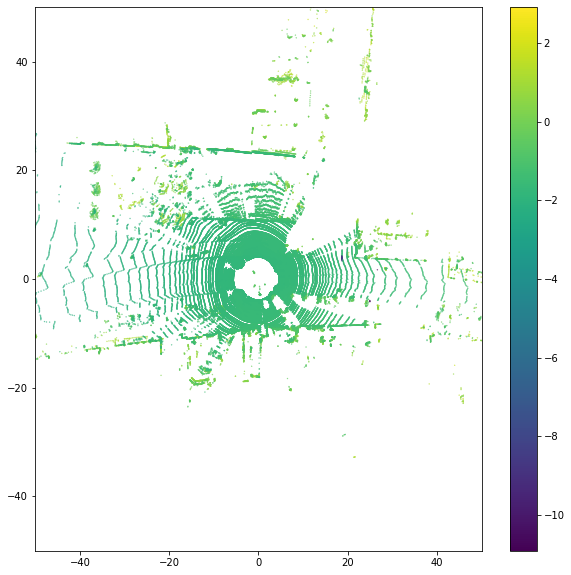

In [12]:
plt.figure(figsize=(10, 10))
plt.scatter(xyzi[:, 0], xyzi[:, 1], c=xyzi[:, 2],  s=0.1)
plt.colorbar()
plt.xlim(-50, 50)
plt.ylim(-50, 50)

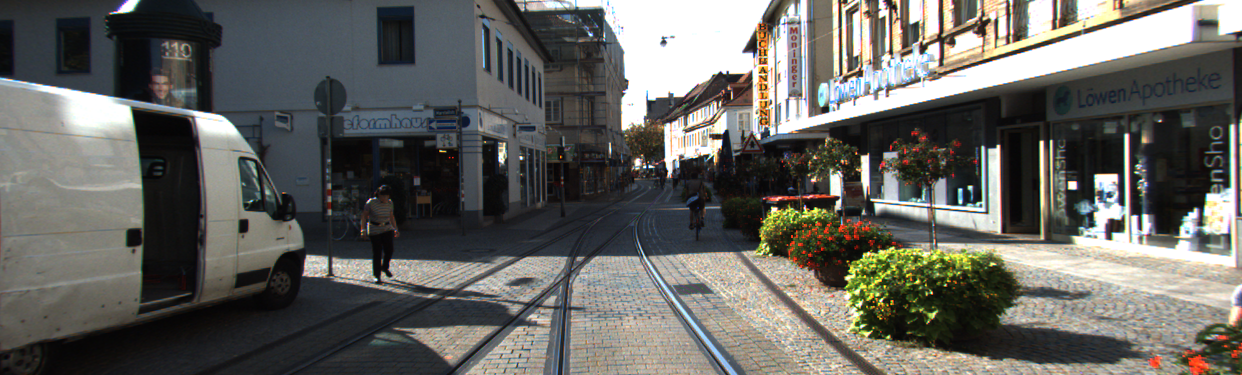

In [13]:
Image.open('kitti_hw_dataset/training/image_2/000100.png')

In [14]:
with open('kitti_hw_dataset/training/calib/000100.txt') as f:
    print(f.read())

P0: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 0.000000000000e+00 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 0.000000000000e+00 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 0.000000000000e+00
P1: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 -3.875744000000e+02 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 0.000000000000e+00 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 0.000000000000e+00
P2: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 4.485728000000e+01 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 2.163791000000e-01 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 2.745884000000e-03
P3: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 -3.395242000000e+02 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 2.199936000000e+00 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 2.729905000000e-03
R0_rect: 9.999239000000e-01 9.837760000000e-03 -7.445048000000e-03 -9.

In [15]:
with open('kitti_hw_dataset/training/label_2/000100.txt') as f:
    print(f.read())

Van 0.63 0 -0.90 0.00 58.65 320.90 374.00 2.46 2.03 5.35 -5.18 1.69 7.24 -1.51
Cyclist 0.00 0 -1.58 684.31 165.66 710.23 242.31 1.82 0.59 1.89 2.13 1.66 18.06 -1.47
Pedestrian 0.00 0 0.84 359.32 182.26 400.32 285.85 1.57 0.52 0.62 -3.63 1.72 11.35 0.54
Car 0.00 2 -2.46 19.88 179.87 206.64 238.00 1.44 1.62 3.91 -13.04 1.64 18.98 -3.05
DontCare -1 -1 -10 650.19 158.35 666.90 192.77 -1 -1 -1 -1000 -1000 -1000 -10



### Смотрим на предсказания детектора

In [16]:
dataset = kitti_object.kitti_object('kitti_hw_dataset')

In [17]:
IMAGE_ID = 8

xyzi        = dataset.get_lidar(IMAGE_ID)
image       = dataset.get_image(IMAGE_ID)
calibration = dataset.get_calibration(IMAGE_ID)

In [18]:
def filter_vehicles(objects):
    return [obj for obj in objects if obj.type in ['Car', 'Van']]

In [19]:
vehicles = filter_vehicles(dataset.get_label_objects(IMAGE_ID))

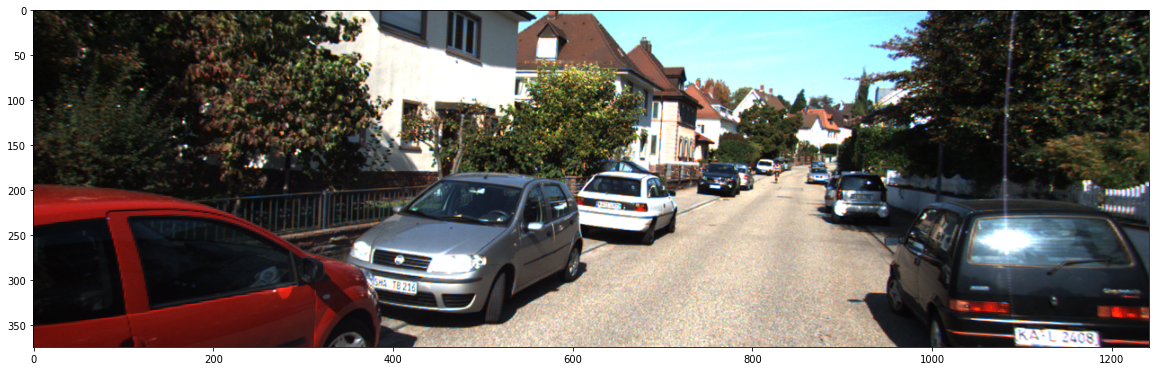

In [20]:
plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

(-40.0, 40.0)

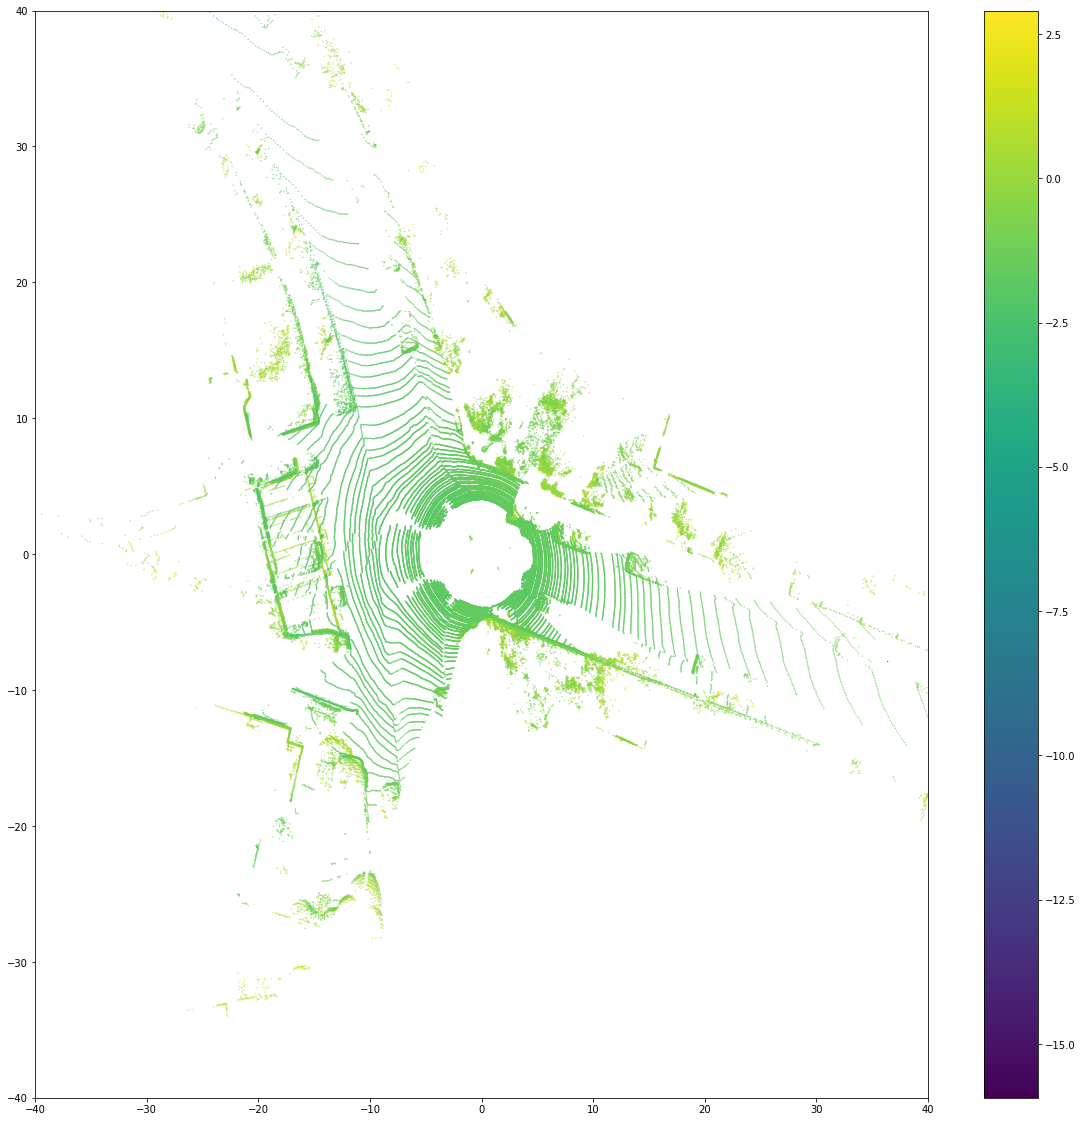

In [21]:
plt.figure(figsize=(20, 20))
plt.scatter(xyzi[:, 0], xyzi[:, 1], c=xyzi[:, 2],  s=0.1)
plt.colorbar()
plt.xlim(-40, 40)
plt.ylim(-40, 40)

In [22]:
ssd = SSD('tmp')

In [23]:
pipeline = PipelineDetector(pointnet, ssd, 0.5)
scene = pipeline.predict(xyzi, image, calibration)

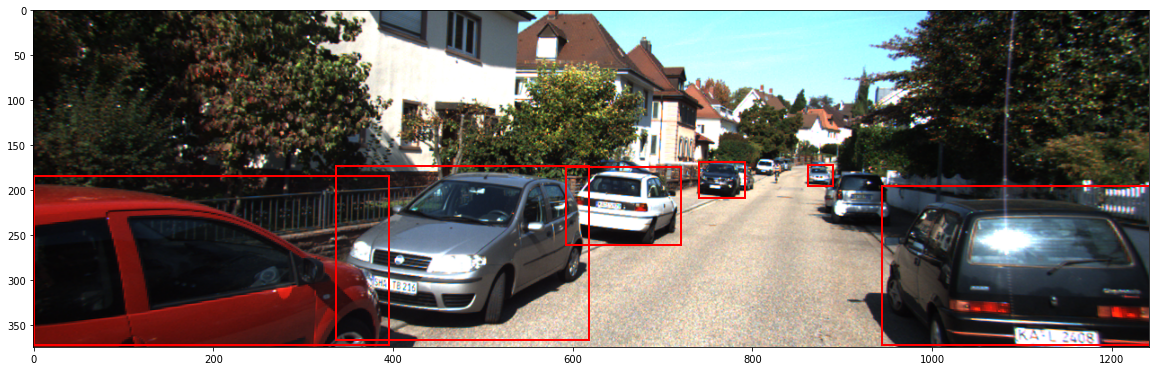

In [24]:
boxes = pipeline._get_image_boxes(image)

plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

for box in boxes:
    y1, x1, y2, x2 = box
    plt.gca().add_patch(Rectangle((x1,y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none'))

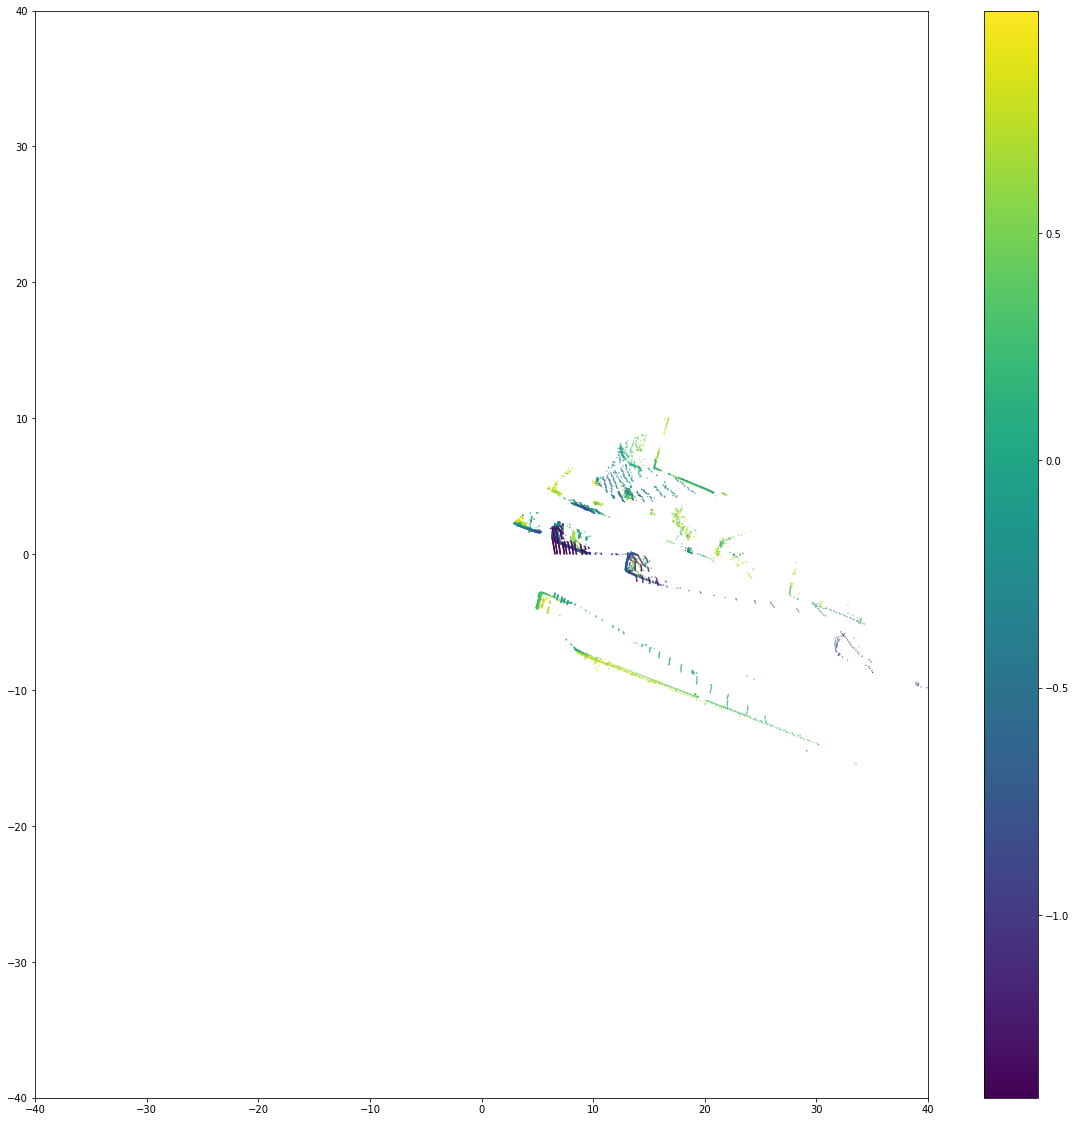

In [25]:
# filtered lidar

plt.figure(figsize=(20, 20))

for box in boxes:
    points = pipeline._filter_points_in_box(xyzi[:, :3], box, calibration)
    plt.scatter(points[:, 0], points[:, 1], c=points[:, 2],  s=0.1)
    plt.xlim(-40, 40)
    plt.ylim(-40, 40)

plt.colorbar()
plt.show()

### Сравниваем с ответом

In [26]:
vehicle = filter_vehicles(dataset.get_label_objects(IMAGE_ID))

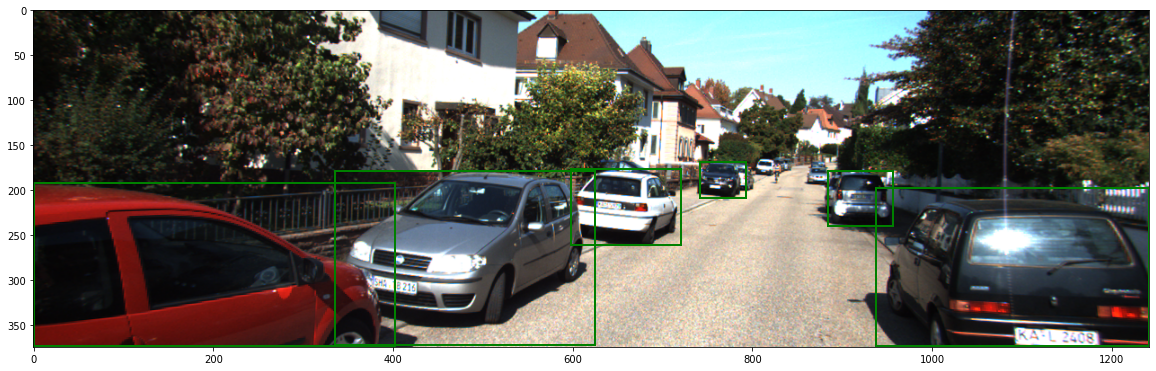

In [27]:
plt.figure(figsize=(20,20))

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

for car in vehicles:
    plt.gca().add_patch(Rectangle((car.xmin,car.ymin),car.xmax-car.xmin,car.ymax-car.ymin,linewidth=2,edgecolor='g',facecolor='none'))

In [28]:
for vehicle in vehicles:
    print(vehicle.t)

(-2.7, 1.74, 3.68)
(-1.17, 1.65, 7.86)
(3.81, 1.64, 6.15)
(1.07, 1.55, 14.44)
(7.24, 1.55, 33.2)
(8.48, 1.75, 19.96)


In [29]:
for detection in scene.detections:
    print(detection.xyz)

[-2.66522944  1.4996145   3.77164281]
[ 1.11836405  1.61093777 14.40295023]
[3.88525887 1.73925474 6.27051428]
[-1.16765342  1.56012353  7.82437387]
[20.12630107  1.67255058 55.01266255]
[ 7.10944193  1.53436532 33.42844011]


(-40.0, 40.0)

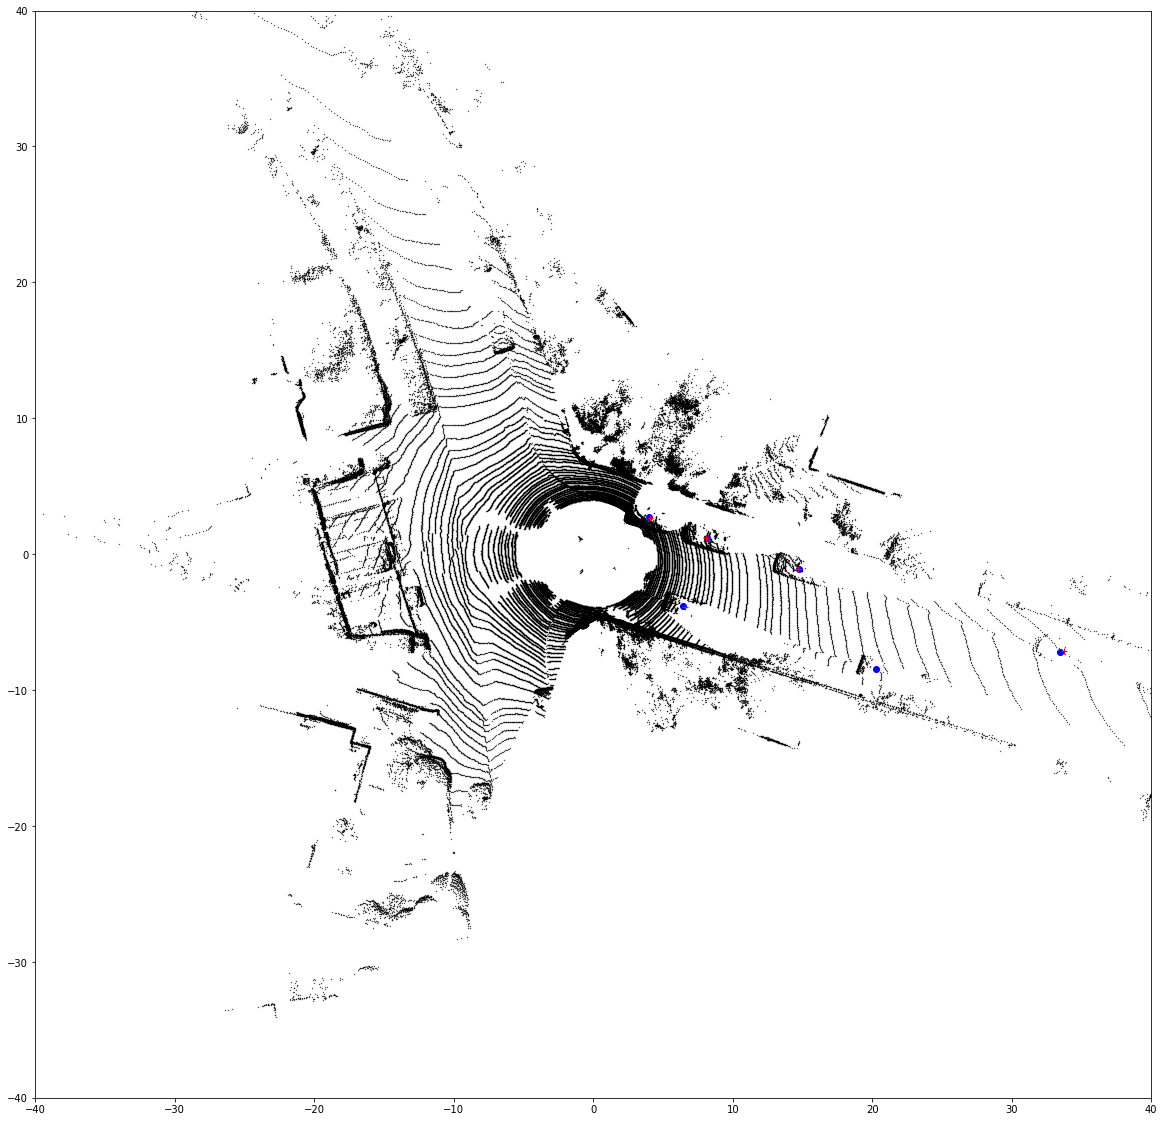

In [31]:
plt.figure(figsize=(20, 20))
# ground truth [blue]
for vehicle in vehicles:
    x, y, z = calibration.project_rect_to_velo(np.asarray([vehicle.t]))[0]
    plt.plot([x], [y], 'bo')
    
# predictions [red]
for detection in scene.detections:
    x, y, z = calibration.project_rect_to_velo(np.asarray([detection.xyz]))[0]
    plt.plot([x], [y], 'r+')
    
plt.scatter(xyzi[:, 0], xyzi[:, 1], c='black',  s=0.1)
plt.xlim(-40, 40)
plt.ylim(-40, 40)

In [34]:
for detection in scene.detections:
    print(detection)

Detection(xyz=array([-2.66522944,  1.4996145 ,  3.77164281]), angle=-1.1349277072034911, lwh=array([3.80471683, 1.57488894, 1.47157363]), confidence=1.0)
Detection(xyz=array([ 1.11836405,  1.61093777, 14.40295023]), angle=-1.2647237150690172, lwh=array([3.71161781, 1.58956858, 1.50330543]), confidence=1.0)
Detection(xyz=array([3.88525887, 1.73925474, 6.27051428]), angle=-1.3049503919225125, lwh=array([3.46296356, 1.51334658, 1.50958294]), confidence=1.0)
Detection(xyz=array([-1.16765342,  1.56012353,  7.82437387]), angle=1.878337542365561, lwh=array([3.68260441, 1.57288823, 1.51800792]), confidence=1.0)
Detection(xyz=array([20.12630107,  1.67255058, 55.01266255]), angle=1.891442025550336, lwh=array([3.7440599 , 1.63507658, 1.53134183]), confidence=0.9999999)
Detection(xyz=array([ 7.10944193,  1.53436532, 33.42844011]), angle=1.8752771989138584, lwh=array([4.1089057 , 1.69368049, 1.71927718]), confidence=0.9999993)


In [118]:
def to_rectangle(xyz, lwh, alpha, calibration=None):
    if calibration is not None:
        xyz = calibration.project_rect_to_velo(np.asarray([xyz]))[0]
    x, y, _ = xyz
    l, w, _ = lwh
    rect = Polygon([[  w / 2.,   l / 2.], 
                    [  w / 2., - l / 2.],
                    [- w / 2., - l / 2.],
                    [- w / 2.,   l / 2.]])
    rect = rotate(rect, - alpha, use_radians=True)
    coords = np.array(rect.exterior.coords)
    coords[:, 0] += x
    coords[:, 1] += y
    return Polygon(list(coords))

def detections_to_rects(detections, calibration):
    return [to_rectangle(detection.xyz, detection.lwh, detection.angle, calibration) for detection in detections]

def vehicles_to_rects(vehicles, calibrations):
    res = []
    for vehicle in vehicles:
        lwh = (vehicle.l, vehicle.w, vehicle.h)
        rect = to_rectangle(vehicle.t, lwh, vehicle.alpha, calibration)
        res.append(rect)
    return res

def filter_by_dist(rects, threshold=40.):
    def dist(rect):
        center = np.array(rect.exterior.coords).mean(axis=0)
        return np.linalg.norm(center)
    return [rect for rect in rects if dist(rect) < threshold]

(-40.0, 40.0)

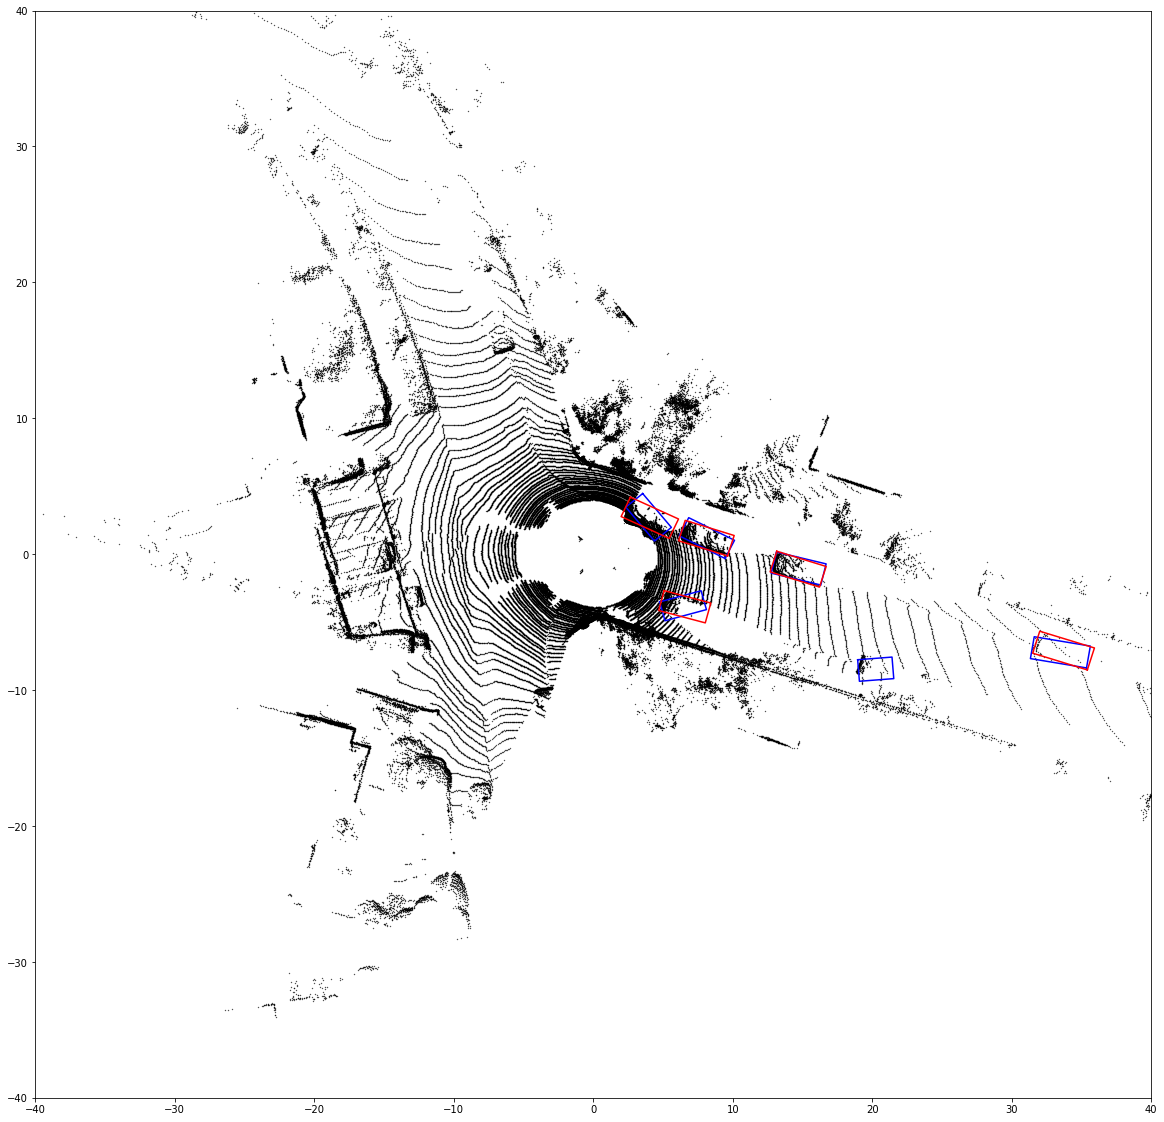

In [90]:
plt.figure(figsize=(20, 20))

# ground truth [blue]
vehicle_rects = vehicles_to_rects(vehicles, calibration)
for rect in vehicle_rects:
    coords = np.array(rect.exterior.coords)
    plt.plot(coords[:, 0], coords[:, 1], 'b')

# predictions [red]
rects = detections_to_rects(scene.detections, calibration)
for rect in rects:
    coords = np.array(rect.exterior.coords)
    plt.plot(coords[:, 0], coords[:, 1], 'r')
    
plt.scatter(xyzi[:, 0], xyzi[:, 1], c='black',  s=0.1)
plt.xlim(-40, 40)
plt.ylim(-40, 40)

### Evaluation

In [97]:
def match(rect_a, rect_b, threshold=0.7):
    a_area = rect_a.area
    b_area = rect_b.area
    common = rect_a.intersection(rect_b).area
    return common / (a_area + b_area - common) > threshold

gt_rects = vehicles_to_rects(vehicles, calibration)
rects = detections_to_rects(scene.detections, calibration)

for rect_a in gt_rects:
    for rect_b in rects:
        if match(rect_a, rect_b):
            print(f"match: {np.array(rect_a.exterior.coords)} {np.array(rect_b.exterior.coords)}")

match: [[ 9.45145815 -0.3145749 ]
 [ 6.16916071  1.34943338]
 [ 6.84742496  2.68732635]
 [10.12972239  1.02331808]
 [ 9.45145815 -0.3145749 ]] [[ 9.62971915 -0.12386138]
 [ 6.11989972  0.99092239]
 [ 6.59603837  2.49001191]
 [10.10585779  1.37522814]
 [ 9.62971915 -0.12386138]]
match: [[13.1421429   0.15959253]
 [16.69654596 -0.71322983]
 [16.31498428 -2.26706723]
 [12.76058121 -1.39424488]
 [13.1421429   0.15959253]] [[13.16208637  0.21557178]
 [16.70120416 -0.90279846]
 [16.22224154 -2.41849073]
 [12.68312375 -1.3001205 ]
 [13.16208637  0.21557178]]
match: [[35.36261205 -8.36795151]
 [31.3408778  -7.68088992]
 [31.61536564 -6.07416766]
 [35.63709989 -6.76122924]
 [35.36261205 -8.36795151]] [[35.42329507 -8.51445426]
 [31.50338788 -7.28261269]
 [32.01114985 -5.66683691]
 [35.93105704 -6.89867848]
 [35.42329507 -8.51445426]]


In [98]:
len(dataset)

7481

In [129]:
def calculate_map(pipeline, dataset, limit=None):
    precisions = []
    
    n = len(dataset)
    if limit is not None:  
        n = min(n, limit)
    
    for i in tqdm.tqdm(range(n)):
        image = dataset.get_image(i)
        xyzi  = dataset.get_lidar(i)
        calibration = dataset.get_calibration(i)
        
        vehicles = filter_vehicles(dataset.get_label_objects(i))
        gt_rects = vehicles_to_rects(vehicles, calibration)
        gt_rects = filter_by_dist(gt_rects)
        
        if len(gt_rects) < 1:
            continue
            
        scene = pipeline.predict(xyzi, image, calibration)
        rects = detections_to_rects(scene.detections, calibration)
        
        found = 0
        for gt_rect in gt_rects:
            for rect in rects:
                if match(gt_rect, rect):
                    found += 1
                    break
        
        precision = found / len(gt_rects)
        precisions.append(precision)
    return np.average(precisions)

In [ ]:
calculate_map(pipeline, dataset, limit=11)

 82%|████████▏ | 9/11 [00:43<00:12,  6.44s/it]